# Математические пакеты
## Лабораторная работа №1

Цель работы – изучить возможности библиотек Python для решения задач цифровой
обработки сигналов.

## Задачи

1. Освоить Jupyter Notebook.
2. Выполнить загрузку аудио сигнала и построить огибающую (график).
3. Фильтрация (выбрать один из 4 основных типов фильтров). Получить фильтрованный
сигнал.
4. Детектор сигнал/шум. Получить сигнал после детектирования
5. Эффект ”Эхо”. Получить сигнал после работы аудио-эффекта.
6. Бонусное задание: эффект ”Distortion”(классический вариант). Получить сигнал после
работы аудио-эффекта.

## 2. Выполнить загрузку аудио сигнала и построить огибающую (график).

In [1]:
from scipy.io.wavfile import read, write
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import hilbert, chirp, filtfilt, butter

192192 192192


<ipython-input-2-a52d022a9b3f>:1: WavFileWarning: Chunk (non-data) not understood, skipping it.
  samplerate, data = read('03-01-05-01-01-02-16_A16.wav')
<ipython-input-2-a52d022a9b3f>:1: WavFileWarning: Incomplete chunk ID: b'\x00', ignoring it.
  samplerate, data = read('03-01-05-01-01-02-16_A16.wav')


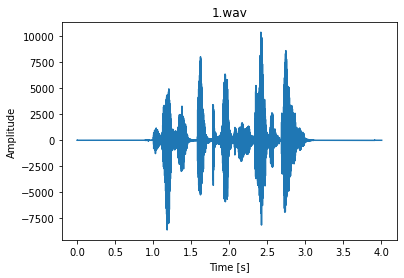

In [2]:
samplerate, data = read('03-01-05-01-01-02-16_A16.wav')
duration = len(data)/samplerate
time = np.arange(0,duration,1/samplerate)
plt.plot(time,data)
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.title('1.wav')
plt.show()

In [3]:
import IPython.display as ipd
ipd.Audio('./03-01-05-01-01-02-16_A16.wav')

In [4]:
def getTime(data, n):
    time1 = [0.0]
    k = time[-1]/n
    current = time[0]
    for i in range(1, n):
        current+=k
        time1.append(current)
    return time1

### Задание параметров

In [5]:
N = len(data)
n = 1000
m = int(N/n)

### Построение огибающей по среднему значеннию в интервале

$$Сигнал - x(i), i=0,1,...,N-1$$
$$Огибающая - y(j), j=0,1,...,n-1$$
$$Число\ точек\ в\ интервале\ усреднения\ -\ m = \left[ {N\over n} \right]$$
$$y(i) = \sum\limits_{k=mj}^{mj+m-1}|x(k)|$$

In [6]:
def getEnvelopSum(data, n, m):
    absData = np.abs(data)
    resultValue = []
    for j in range(n):
        k = m*j
        value = 0
        while(k <= m*j+m-1):
            value += absData[k]
            k += 1 
        resultValue.append((1/m)*value)
    return resultValue

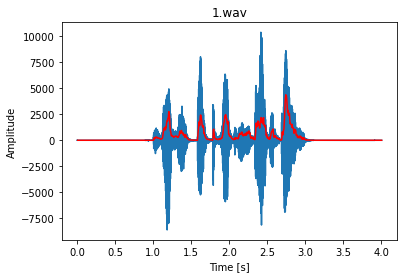

In [22]:
envelop = getEnvelopSum(data, n, m) 
time1 = []
interval = time[-1]/n
for i in range(n):
    if i == 0:
        time1.append(interval)
    else:
        time1.append(time1[i-1]+interval)

plt.plot(time, data)
plt.plot(time1,envelop, "r")
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.title('1.wav')
plt.show()    

## 3. Фильтр низких частот

$$Пусть\ F_d — частота\ дискретизации,\ частота\ среза\ — F_s. Порядок\ фильтра\ — m. Тогда\
вычисляем$$
$$wn = 2{F_s\over F_d}$$

In [8]:
def filter(fd, fs, m, data):
    wn = 2*(fs/fd)
    b, a = butter(m, wn, 'lowpass')
    filtedData = filtfilt(b, a, data)
    return filtedData.astype(np.int16)

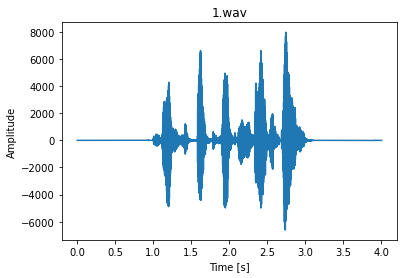

In [9]:
filtedData = filter(samplerate, 2500, 1, data)
duration = len(data)/samplerate
time = np.arange(0,duration,1/samplerate)
plt.plot(time,filtedData)
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.title('1.wav')
plt.show()
write("low.wav", samplerate, filtedData)

In [10]:
import IPython.display as ipd
ipd.Audio('./low.wav')

## 4. Амплитудный детектор

$$Определяем\ среднее\ сигнала\ по\ амплитуде\ (без\ учета\ знака):$$
$$mid={1\over N} \sum\limits_{k=0}^{N-1}|x(k)|$$

$$Th = \alpha*mid\ , где\ 0< \alpha <1$$

In [11]:
def mid(data):
    absData = np.abs(data)
    summ = 0
    for i in absData:
        summ += i
    return summ/len(data)
        

### Константы

In [23]:
midi = mid(data)
Th = 0.25*midi
k = 50

In [13]:
isStart = False
isEnd = True
counter = 0
valueArr = []
for i in data:
    
    if abs(i) > Th and  not isStart:
        counter += 1
        
    elif abs(i) > Th and isStart:
        counter = 0
        
    elif abs(i) < Th and isEnd:
        counter = 0
        
    elif abs(i) < Th and not isEnd:
        counter += 1
    
    if isStart:
        valueArr.append(i)
    elif isEnd == True:
        valueArr.append(0)
        
    if not isStart and counter == k:
        isStart = True
        isEnd = False
        counter = 0
    elif not isEnd and counter == k:
        isStart = False
        isEnd = True
        counter = 0


        

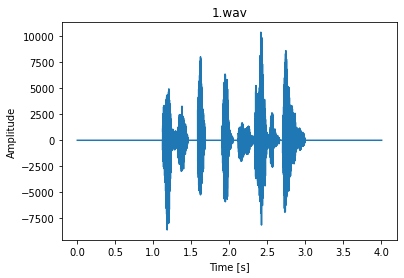

In [24]:
plt.plot(time, valueArr)
valueArr = np.array(valueArr)
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.title('1.wav')
plt.show()    
write("detector.wav", samplerate, valueArr.astype(np.int16))


In [15]:
import IPython.display as ipd
ipd.Audio('./detector.wav')

## 5. Ревербератор

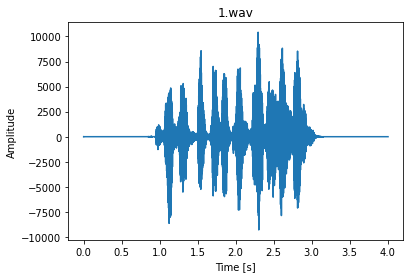

In [25]:
from itertools import zip_longest
D = []
D.append(10000)
i = 2
while(i <= 8):
    D.append(D[0]*2**((1-i)/8))
    i += 1
alpha = [0.9/(2**i) for i in range(8)]
new_signal = [data for i in range(8)]
for i in range(len(new_signal)):
    for j in range(round(D[i])):
        new_signal[i] = np.insert(new_signal[i],0,0)
        
for i in range(len(new_signal)):
    for j in range(len(new_signal[i])):
        new_signal[i][j] = new_signal[i][j]*alpha[i]
echo_array = []
for i in new_signal:
    echo_array = [x+y for x, y in zip_longest(echo_array, i, fillvalue=0)]
    
echo_array = filter(samplerate, 1500, 4, echo_array)
echo_array = [x+y for x, y in zip_longest(echo_array, data, fillvalue=0)]
time1 = []
interval = time[-1]/len(echo_array)
for i in range(len(echo_array)):
    if i == 0:
        time1.append(interval)
    else:
        time1.append(time1[i-1]+interval)
plt.plot(time1, echo_array)
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.title('1.wav')
plt.show()  
write("echo.wav",samplerate, np.array(echo_array).astype(np.int16)) 

In [27]:
import IPython.display as ipd
ipd.Audio('./echo.wav')

## 6. Классический distortion

$$Обозначим\ входной\ сигнал\ и\ выходной\ сигналы,\ соответственно\ как\
x(i)\ и\ y(i)\ i = 0,1, . . . ,N − 1 \\
Пользователь\ задает\ порог\ — Th\ и\ максимальное\ значение\
сигнала\ Max > Th. Тогда$$
$$\begin{equation*}
Y(i) = 
 \begin{cases}
   x(i), &\text{$|x(i)|$ $\leqslant Th$}\\
   Max*sign(x(i)), &\text{$|x(i)| > Th $}
 \end{cases}
\end{equation*}$$

### Константы

In [28]:
def Distortion(x):
    y = []
    for i in x:
        if abs(i) <= Th:
            y.append(i)
        else:
            y.append(Max*np.sign(i))
    return y

In [29]:
Th = 3000
Max = 7000

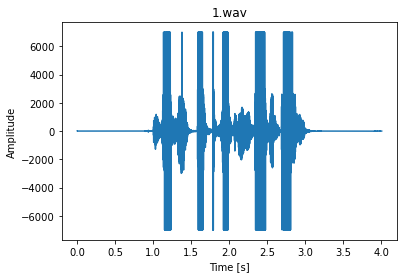

In [30]:
distArr = Distortion(data)
plt.plot(time, distArr)
distArr = np.array(distArr)
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.title('1.wav')
plt.show()    
write("distortion.wav", samplerate, distArr.astype(np.int16))


In [31]:
import IPython.display as ipd
ipd.Audio('./distortion.wav')

## Вывод

В ходе выполнения лабораторной работы были изучены возможности библиотек Python для решения задач цифровой обработки сигналов. 